In [53]:
from itertools import permutations, pairwise
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import s3fs
import os

In [80]:
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
FILE_PATH = "romaintailhurat/bowie/bowie_redirection_filtre.csv"

fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

with fs.open(FILE_PATH, mode="rb") as f:
    df = pl.read_csv(f, sep=",")

#proprietaires = [prop.strip("\"") for prop in df["proprietaire"]]
proprietaires = sorted(set(df["proprietaire"]))
    
df.head()

id,label,proprietaire,flow,modified
str,str,str,str,str
"""kxhgx564""","""""SINE 2022 au...","""""DR67-SES54""""","""""FILTER""""","""""Wed Dec 22 20..."
"""kfp3p6nk-nm""","""""Déchets 2020 ...","""""DR14-SSNE""""","""""FILTER""""","""""Fri Jun 18 20..."
"""kwxny32z""","""""Test Mise en ...","""""DR59-SNDI""""","""""REDIRECTION""""","""""Thu Feb 10 20..."
"""kzgycn1p""","""""Test Mise en ...","""""DR59-SNDI""""","""""REDIRECTION""""","""""Thu Feb 10 20..."
"""l7u2lpo7""","""""SINE 2022 """"","""""DR67-SES54""""","""""FILTER""""","""""Fri Sep 09 20..."


In [3]:
df_y = df.with_columns(pl.col("modified").str.split(" ").arr.get(3).alias("ANNEE"))

In [93]:
df_rf = df_y.groupby(["ANNEE", "flow"]).agg(pl.count()).sort("ANNEE")
df_rf = df_rf.filter(pl.col("ANNEE").is_not_null())
df_rf

ANNEE,flow,count
str,str,u32
"""2018""","""""REDIRECTION""""",35
"""2019""","""""REDIRECTION""""",115
"""2020""","""""REDIRECTION""""",122
"""2021""","""""",1
"""2021""","""""FILTER""""",116
"""2021""","""""REDIRECTION""""",141
"""2022""","""""FILTER""""",267
"""2022""","""""REDIRECTION""""",56
"""2023""","""""FILTER""""",145


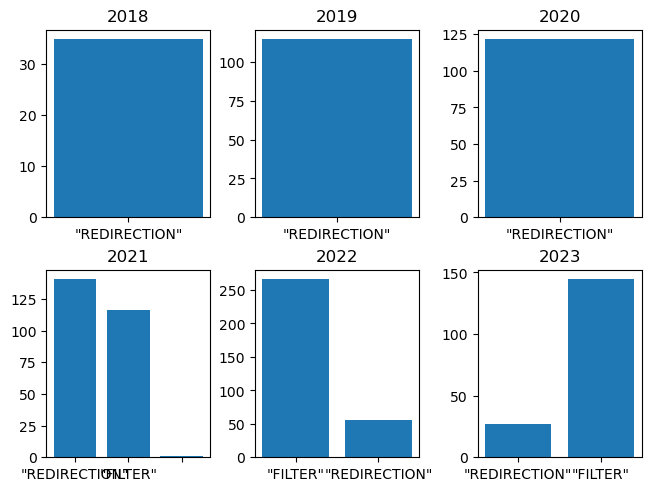

In [40]:
fig, axs = plt.subplots(2, 3, layout="constrained")

years = sorted(set(df_rf["ANNEE"]))

n=0

for i in range(2):
    for j in range(3):
        df = df_rf.filter(pl.col("ANNEE") == years[n])
        axs[i, j].bar(df["flow"], df["count"])
        axs[i, j].set_title(years[n])        
        n += 1

plt.show()

In [52]:
selected_year  = widgets.Dropdown(
    options=years,
    value=years[0],
    description='Number:',
    disabled=False,
)
display(selected_year)
print(selected_year.value)

Dropdown(description='Number:', options=('2018', '2019', '2020', '2021', '2022', '2023'), value='2018')

2018


In [91]:
@interact(y=years, p=proprietaires, r=["\"REDIRECTION\"", "\"FILTER\""])
def filter_df(y="2023", p="\"DG75-L120\"", r="\"REDIRECTION\""):
    #df_prop = df_y.groupby(["ANNEE", "proprietaire", "flow"]).agg(pl.count()).sort("ANNEE")
    return df_y.filter(
        (pl.col("ANNEE") == y) & (pl.col("proprietaire") == p) & (pl.col("flow") == r)
    )

interactive(children=(Dropdown(description='y', index=5, options=('2018', '2019', '2020', '2021', '2022', '202…

In [90]:
df_prop = df_y.groupby(["ANNEE", "proprietaire", "flow"]).agg(pl.count()).sort("ANNEE")
df_prop.filter(pl.col("proprietaire") == "\"DG75-L120\"")

ANNEE,proprietaire,flow,count
str,str,str,u32
"""2020""","""""DG75-L120""""","""""REDIRECTION""""",2
"""2021""","""""DG75-L120""""","""""REDIRECTION""""",2
"""2021""","""""DG75-L120""""","""""FILTER""""",4
"""2022""","""""DG75-L120""""","""""FILTER""""",9
"""2022""","""""DG75-L120""""","""""REDIRECTION""""",2
"""2023""","""""DG75-L120""""","""""REDIRECTION""""",2
"""2023""","""""DG75-L120""""","""""FILTER""""",4
